<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/source/load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does performance in regular season predict playoff ranking? 
- supervised offline multi-class classification task
- performance measure: confusion matrix
- data source: https://www.nba.com/stats/teams/traditional/?sort=W&dir=-1&Season=2021-22&SeasonType=Regular%20Season 

In [ ]:
!pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from nba_api.stats.endpoints import leaguedashteamstats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import os
from zlib import crc32
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import seaborn as sns

# Gather data with [nba api](https://github.com/swar/nba_api)
- stats adjusted per 100 posessions, instead of per game, to account for the different pace each team plays at
- [glossary](https://www.nba.com/stats/help/glossary/) for column names  
- extra data: [advanced team stats](https://www.nba.com/stats/teams/advanced/?sort=W&dir=-1) 



In [ ]:

def season_vs_playoff(start_year, end_year):
  output = None
  season_list = [str(i) + '-' + str(i+1)[2:] for i in range(start_year, end_year)]
  for season in season_list:
    season_df = leaguedashteamstats.LeagueDashTeamStats(
        per_mode_detailed='Per100Possessions', 
        season=season, 
        season_type_all_star='Regular Season').get_data_frames()[0]
    playoff_df = leaguedashteamstats.LeagueDashTeamStats(
        per_mode_detailed='Per100Possessions', 
        season=season, 
        season_type_all_star='Playoffs',
        po_round_nullable=0).get_data_frames()[0]
    # win 4 games = win 1 round
    # ranking = 0 for teams which didn't enter playoffs
    # ranking = 5 for champion which won 4 rounds, 16 games
    if playoff_df['W'].max() == 16:
      # to win a championship, you need to win 4 rounds of best-of-7 (4,4,4,4)
      playoff_df['PLAYOFF_RANKING'] = playoff_df['W'].apply(lambda x: int(x/4) + 1)
    elif playoff_df['W'].max() == 15:
      # 2001-02 season is the last season with best-of-5 in 1st round (3,4,4,4) so lets add 1 back to make ranking easier
      playoff_df['PLAYOFF_RANKING'] = playoff_df['W'].apply(lambda x: int((x+1)/4) + 1)

    playoff_df = playoff_df[['TEAM_ID', 'PLAYOFF_RANKING']] 

    season_vs_playoff = pd.merge(season_df, playoff_df, on='TEAM_ID', how = 'outer')
    season_vs_playoff.fillna(0, inplace=True) # teams which are not in playoff will have 0 as PLAYOFF_RANKING
    season_vs_playoff['PLAYOFF_RANKING'] = season_vs_playoff['PLAYOFF_RANKING'].astype(int)
    season_vs_playoff['SEASON'] = season
    output = pd.concat([output,season_vs_playoff.sort_values(by='PLAYOFF_RANKING', ascending = False).reset_index(drop=True)], axis = 0)
  
  return output

In [ ]:
df = season_vs_playoff(start_year = 1996, end_year = 2022)
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,82,69,13,0.841,52.5,43.6,92.0,0.473,...,26,1,2,7,1,1,10,Chicago Bulls,5,1996-97
1,1610612762,Utah Jazz,82,64,18,0.780,52.7,41.6,82.7,0.504,...,12,9,26,6,2,2,10,Utah Jazz,4,1996-97
2,1610612745,Houston Rockets,82,57,25,0.695,51.7,39.6,84.5,0.468,...,24,7,1,13,7,7,10,Houston Rockets,3,1996-97
3,1610612748,Miami Heat,82,61,21,0.744,53.6,38.2,84.3,0.453,...,7,14,25,4,12,5,10,Miami Heat,3,1996-97
4,1610612737,Atlanta Hawks,82,56,26,0.683,54.2,38.5,86.3,0.446,...,9,6,4,27,8,4,10,Atlanta Hawks,2,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,1610612752,New York Knicks,82,37,45,0.451,49.7,38.8,88.8,0.437,...,10,15,25,3,23,19,10,New York Knicks,0,2021-22
26,1610612765,Detroit Pistons,82,23,59,0.280,48.6,38.4,89.3,0.431,...,14,27,30,14,28,26,10,Detroit Pistons,0,2021-22
27,1610612745,Houston Rockets,82,20,62,0.244,47.5,38.8,85.1,0.456,...,17,28,21,1,26,29,10,Houston Rockets,0,2021-22
28,1610612754,Indiana Pacers,82,25,57,0.305,48.7,41.6,89.9,0.463,...,3,21,24,23,18,24,10,Indiana Pacers,0,2021-22


In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [ ]:
df.to_csv('nba_season_vs_playoff.csv', index = False)
from google.colab import files
files.download("nba_season_vs_playoff.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('nba_season_vs_playoff.csv')
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,82,69,13,0.841,52.5,43.6,92.0,0.473,7.0,18.7,0.373,18.4,24.6,0.747,16.4,32.7,49.1,28.5,14.7,9.5,4.4,3.8,21.5,0.2,112.4,11.8,1,1,1,1,13,1,1,3,11,10,6,26,28,12,2,3,1,2,2,6,26,1,2,7,1,1,10,Chicago Bulls,5,1996-97
1,1610612762,Utah Jazz,82,64,18,0.780,52.7,41.6,82.7,0.504,4.4,12.0,0.370,24.7,32.1,0.769,11.8,32.0,43.9,29.2,16.7,9.9,5.6,5.0,26.3,0.2,112.4,9.6,1,2,2,2,12,2,28,1,27,29,8,1,1,3,28,8,20,1,10,3,12,9,26,6,2,2,10,Utah Jazz,4,1996-97
2,1610612745,Houston Rockets,82,57,25,0.695,51.7,39.6,84.5,0.468,8.7,24.0,0.365,19.6,26.0,0.755,12.1,33.4,45.5,26.2,17.8,9.0,4.5,4.8,21.0,0.2,107.5,4.8,1,4,4,4,21,9,24,7,3,3,11,19,23,7,26,1,7,5,25,12,24,7,1,13,7,7,10,Houston Rockets,3,1996-97
3,1610612748,Miami Heat,82,61,21,0.744,53.6,38.2,84.3,0.453,9.2,25.2,0.364,19.7,27.4,0.719,12.9,32.5,45.4,23.5,17.7,8.8,5.9,5.3,26.0,0.3,105.2,6.1,1,3,3,3,6,22,26,18,1,1,12,18,13,23,20,5,9,15,21,16,7,14,25,4,12,5,10,Miami Heat,3,1996-97
4,1610612737,Atlanta Hawks,82,56,26,0.683,54.2,38.5,86.3,0.446,9.0,25.1,0.360,20.4,26.8,0.763,14.0,32.2,46.2,21.3,16.8,9.6,5.8,4.5,21.8,0.1,106.4,6.1,1,7,7,7,4,18,11,20,2,2,15,15,17,4,11,7,4,28,13,5,9,6,4,27,8,4,10,Atlanta Hawks,2,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1610612752,New York Knicks,82,37,45,0.451,49.7,38.8,88.8,0.437,13.6,38.1,0.357,18.5,24.9,0.744,11.8,35.7,47.5,22.5,13.7,7.2,5.0,4.8,21.0,21.0,109.7,-0.1,1,19,19,19,3,26,13,27,8,6,13,3,1,26,4,5,2,29,12,24,10,15,25,3,23,19,10,New York Knicks,0,2021-22
768,1610612765,Detroit Pistons,82,23,59,0.280,48.6,38.4,89.3,0.431,11.4,34.9,0.326,17.4,22.2,0.782,11.1,32.2,43.3,23.6,14.3,7.7,4.8,5.2,22.1,20.0,105.6,-7.8,1,28,28,28,16,28,9,29,25,17,29,12,13,13,6,29,25,22,20,10,14,27,30,14,28,26,10,Detroit Pistons,0,2021-22
769,1610612745,Houston Rockets,82,20,62,0.244,47.5,38.8,85.1,0.456,13.3,38.1,0.349,17.2,24.1,0.713,9.4,32.0,41.4,23.2,16.2,7.2,4.6,5.7,20.3,21.8,108.1,-8.4,1,30,30,30,29,27,30,24,10,5,21,16,3,30,23,30,30,25,30,22,17,28,21,1,26,29,10,Houston Rockets,0,2021-22
770,1610612754,Indiana Pacers,82,25,57,0.305,48.7,41.6,89.9,0.463,12.2,35.5,0.344,16.5,21.5,0.768,11.3,32.7,44.0,25.5,14.5,7.1,5.6,4.9,20.5,19.3,111.9,-3.5,1,26,26,26,13,10,5,17,16,15,25,23,21,19,5,27,20,9,24,25,3,21,24,23,18,24,10,Indiana Pacers,0,2021-22


In [ ]:
pd.DataFrame(df.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,PLAYOFF_RANKING,SEASON
0,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,int64,object


In [ ]:
# fix datatypes
df['TEAM_ID'] = df['TEAM_ID'].astype(str)
df['CFID'] = df['CFID'].astype(str)
df['PLAYOFF_RANKING'] = df['PLAYOFF_RANKING'].astype('category')


# Train test split with unique identifier = TEAM_ID + SEASON
- hashing unique identifier
- alternative: stratified sampling by season

In [ ]:
# unique id = team id + season
df['UNIQUE_ID'] = df['TEAM_ID'].astype(str) + df['SEASON'].str.replace('-','')

In [ ]:
# instead of train-test_split by random shuffling, hash the unique identifier for train-test split
# slight modification to the technique from Hands On Machine Learning by Aurélien Géron
def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  threshold = np.quantile(ids.apply(lambda x: crc32(np.int64(x))), test_ratio) # instead of using test_ratio * 2**32 as the threshold, this is more accurate
  in_test_set = ids.apply(lambda x: crc32(np.int64(x)) < threshold) 
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
train_set, test_set = split_data_with_id_hash(df, 0.2, "UNIQUE_ID")

In [ ]:
print(f"size of full dataset: {df.shape}")
print(f"train-test ratio: {train_set.shape[0] / df.shape[0]:0.2} / {test_set.shape[0] / df.shape[0]:0.2}")

size of full dataset: (772, 59)
train-test ratio: 0.8 / 0.2


# Exploratory data analysis
- dataset set can be split into left and right half
- left half = team stats
- right half = team stats (ranked)
- Y = PLAYOFF_RANKING

In [ ]:
pd.DataFrame(train_set.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,category,object,object


In [ ]:
train_set.describe()

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.00000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,79.243112,39.291734,39.951378,0.496026,50.939222,39.34295,86.940681,0.452590,7.676013,21.578282,0.353887,19.093355,25.297731,0.755896,11.867585,32.967747,44.835170,23.273258,15.340194,8.073906,5.151053,5.187682,22.208428,14.027877,105.454457,-0.075203,1.572123,15.273906,15.272285,15.285251,15.390600,15.470016,15.068071,15.599676,15.314425,15.220421,15.416532,15.774716,15.638574,15.555916,15.382496,15.230146,15.252836,15.489465,15.204214,15.606159,15.567261,15.551053,15.110211,15.554295,15.549433,15.491086
std,7.231507,12.858842,12.953497,0.155499,1.998738,1.56598,2.095438,0.016397,2.815860,7.553241,0.021219,2.207375,3.088594,0.029930,1.760447,1.752766,1.850486,1.924681,1.425512,0.948144,0.891047,0.751413,2.257684,10.115921,4.390284,4.904257,3.381827,8.660133,8.660653,8.660797,8.510771,8.699688,8.563849,8.587415,8.760801,8.745131,8.724122,8.604371,8.606702,8.416156,8.613050,8.480815,8.606529,8.622888,8.567368,8.458195,8.533686,8.551282,8.685570,8.572876,8.646253,8.586100
min,50.000000,7.000000,9.000000,0.106000,45.500000,34.20000,80.400000,0.401000,2.100000,8.100000,0.264000,12.800000,17.400000,0.668000,7.700000,27.300000,37.800000,17.800000,11.200000,5.700000,2.400000,3.100000,16.800000,0.000000,91.200000,-15.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,82.000000,29.000000,30.000000,0.380000,49.500000,38.30000,85.600000,0.442000,5.600000,16.000000,0.341000,17.500000,22.900000,0.739000,10.600000,31.800000,43.600000,21.900000,14.300000,7.500000,4.500000,4.700000,20.500000,0.200000,102.700000,-3.400000,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,9.000000,8.000000,8.000000,7.000000,8.000000,8.000000,8.000000
50%,82.000000,40.000000,39.000000,0.506000,51.200000,39.30000,87.000000,0.452000,7.200000,20.100000,0.354000,19.000000,25.300000,0.757000,11.800000,32.900000,44.800000,23.200000,15.300000,8.000000,5.100000,5.200000,22.100000,20.000000,105.100000,0.000000,1.000000,15.000000,15.000000,15.000000,15.000000,16.000000,15.000000,16.000000,15.000000,15.000000,15.000000,16.000000,16.000000,16.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,16.000000,16.000000,15.000000,16.000000,16.000000,16.000000
75%,82.000000,49.000000,49.000000,0.610000,52.500000,40.40000,88.400000,0.464000,9.400000,26.200000,0.368000,20.500000,27.300000,0.776000,13.000000,34.200000,46.100000,24.400000,16.300000,8.700000,5.700000,5.700000,23.700000,21.700000,108.500000,3.400000,1.000000,23.000000,23.000000,23.000000,23.000000,23.000000,22.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,22.000000,22.000000,23.000000,22.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
max,82.000000,73.000000,72.000000,0.890000,56.900000,43.

In [ ]:
# explanatory variable (Y) = PLAYOFF_RANKING
# there will be slight variation in the number of teams in each playoff ranking since we performed a train test split
# but overall the distribution should be similar with
train_set.groupby(['SEASON']).PLAYOFF_RANKING.value_counts().reset_index().pivot(index = 'level_1', columns = 'SEASON', values = "PLAYOFF_RANKING")

SEASON,1996-97,1997-98,1998-99,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22
level_1,,,,,,,,,,,,,,,,,,,,,,,,,,
0,11,10,11,10,11,12,8,10,11,11,12,12,10,11,11,9,10,12,14,12,13,13,13,11,12,13
1,7,7,6,6,7,6,6,7,6,5,6,5,4,5,7,7,6,7,7,7,4,5,5,8,7,5
2,3,3,4,4,4,4,4,4,4,2,2,3,3,2,3,4,2,3,4,3,4,2,3,3,4,4
3,2,2,1,2,1,2,2,1,2,2,1,2,2,2,1,2,2,0,0,1,1,2,2,1,1,2
4,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0
5,1,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1


In [ ]:
# no missing data
train_set.isna().sum()[train_set.isna().sum() != 0]

Series([], dtype: int64)

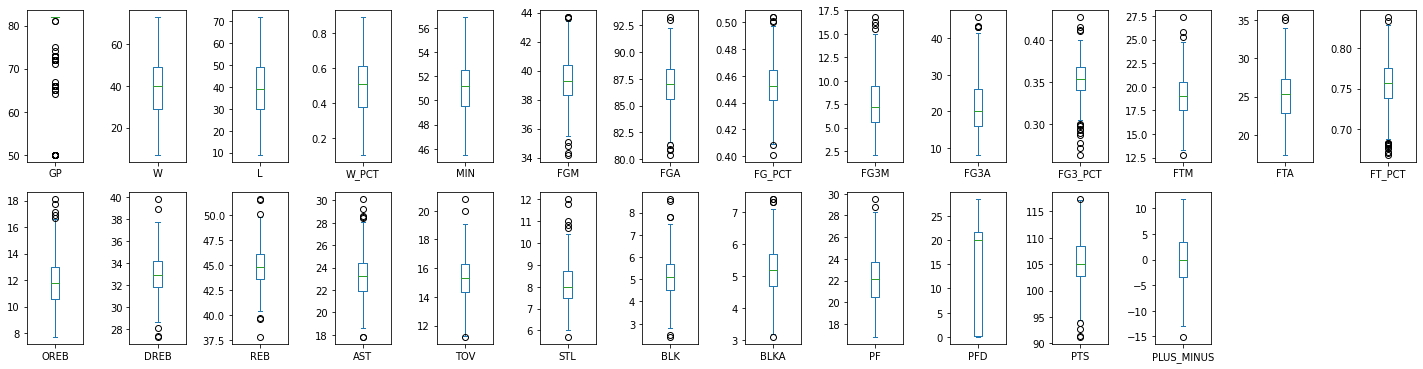

In [ ]:
# plot distributions of each column
# rank of each variable will exhibit uniform distribution
train_set.loc[:,['RANK' not in x for x in train_set.columns]].plot(subplots=True, kind='box', layout = (4,14))
plt.tight_layout()

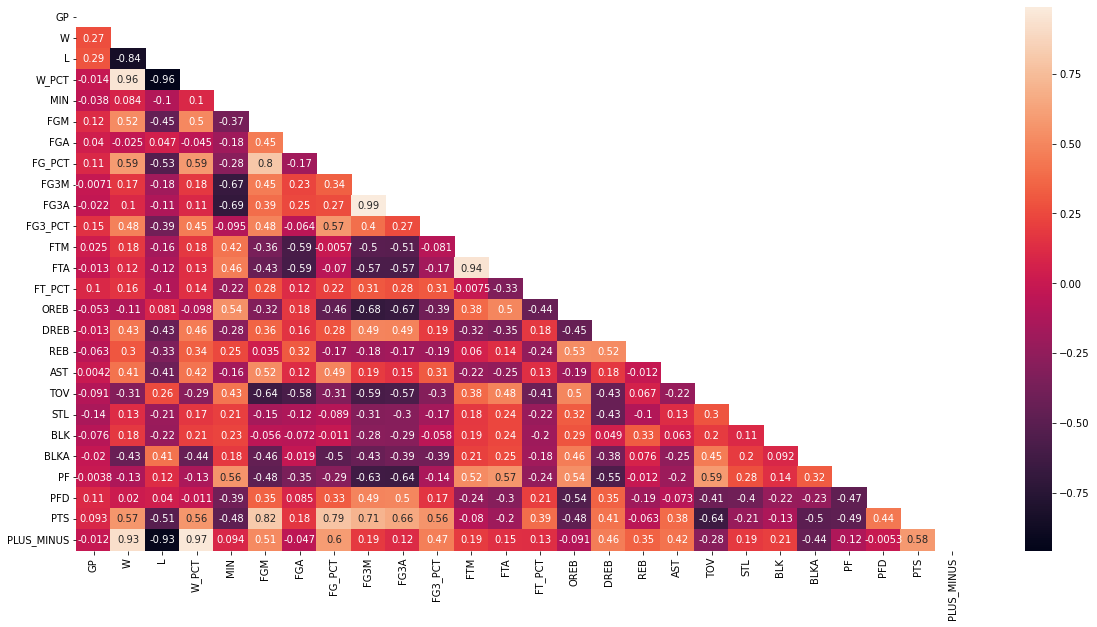

In [ ]:
# normal observations:
## positive correlation between Wins and Plus Minus (net of points scored and lost per 100 posessions)
## negative correlation between FGM, FGA vs defensive stats (STL, BLK, PF) -> perhaps more effort on defensive end means less energy available on offensive end

# interesting observations:
## negative correlation between OREB and (FG3M, FG3A, FG3%) but not so much with FG -> missing shots lead to more OREB and fewer attempts
## positive correlation between DREB and (FG3M, FG3A, FG3%) but not so much with FG -> opponents missing shots lead to more risk taking in shooting 3 instead of 2
corr_mat = train_set.loc[:,['RANK' not in x for x in train_set.columns]].corr()
sns.heatmap(corr_mat, 
            annot=True, 
            mask = np.triu(corr_mat)) # to show only lower triangle

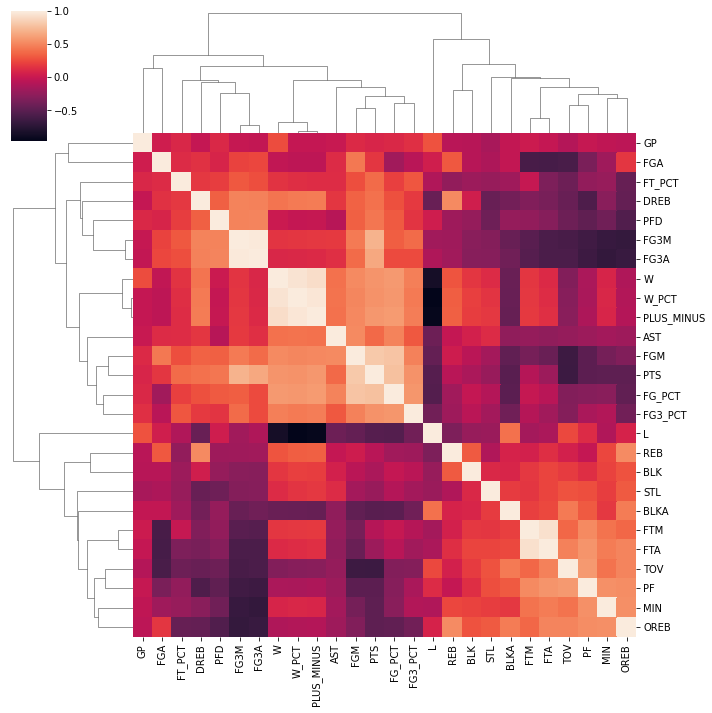

In [ ]:
# use dendrogram to see clusters
sns.clustermap(corr_mat)

Text(0.5, 1.0, 'Z score of NBA league average across regular seasons')

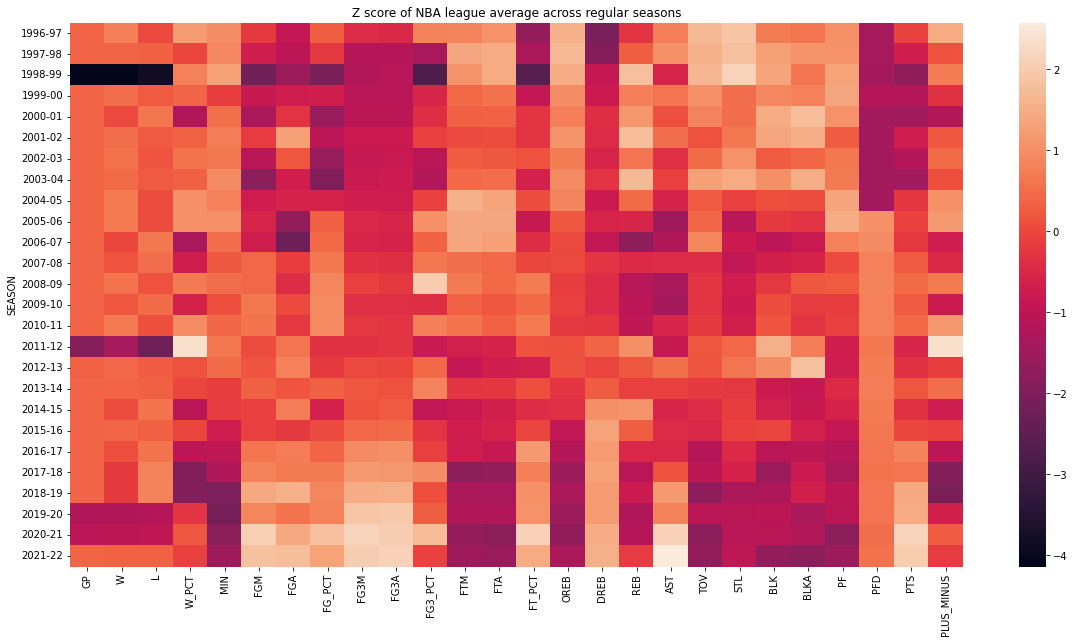

In [ ]:
# it's often mentioned that NBA teams in different era play with different styles
# we have already adjusted the stats per possession so pace doesn't impact the numbers here
# in 90s, teams play more defense and are more physical (higher PF, BLK, STL, TOV)
# in recent era, teams shoot more 3s and score more points (FG and FG3)
# Feature engineering: OneHotEncoder for SEASON to take into account this difference 
from scipy.stats import zscore
sns.heatmap(train_set.loc[:,['RANK' not in x for x in train_set.columns]].groupby('SEASON').mean().apply(zscore))
plt.title("Z score of NBA league average across regular seasons")

# Data cleaning
- SEASON to categorical (OneHotEncoding)
- remove ranking columns?
- remove CFID and CFPARAMS (duplicate)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
abc = cat_encoder.fit_transform(train_set['PLAYOFF_RANKING'].to_frame())


array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

# add feature to cluster similar seasons together (different era have different winning formula)

In [ ]:
df = pd.read_csv('nba_season_vs_playoff.csv')
df

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,...,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,CFID,CFPARAMS,PLAYOFF_RANKING,SEASON
0,1610612741,Chicago Bulls,82,69,13,0.841,52.5,43.6,92.0,0.473,...,26,1,2,7,1,1,10,Chicago Bulls,5,1996-97
1,1610612762,Utah Jazz,82,64,18,0.780,52.7,41.6,82.7,0.504,...,12,9,26,6,2,2,10,Utah Jazz,4,1996-97
2,1610612745,Houston Rockets,82,57,25,0.695,51.7,39.6,84.5,0.468,...,24,7,1,13,7,7,10,Houston Rockets,3,1996-97
3,1610612748,Miami Heat,82,61,21,0.744,53.6,38.2,84.3,0.453,...,7,14,25,4,12,5,10,Miami Heat,3,1996-97
4,1610612737,Atlanta Hawks,82,56,26,0.683,54.2,38.5,86.3,0.446,...,9,6,4,27,8,4,10,Atlanta Hawks,2,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1610612752,New York Knicks,82,37,45,0.451,49.7,38.8,88.8,0.437,...,10,15,25,3,23,19,10,New York Knicks,0,2021-22
768,1610612765,Detroit Pistons,82,23,59,0.280,48.6,38.4,89.3,0.431,...,14,27,30,14,28,26,10,Detroit Pistons,0,2021-22
769,1610612745,Houston Rockets,82,20,62,0.244,47.5,38.8,85.1,0.456,...,17,28,21,1,26,29,10,Houston Rockets,0,2021-22
770,1610612754,Indiana Pacers,82,25,57,0.305,48.7,41.6,89.9,0.463,...,3,21,24,23,18,24,10,Indiana Pacers,0,2021-22


# Feature scaling + PCA for axis orientation issue with decision tree